In [2]:
import numpy as np
import pandas as pd
import os
import pathlib as Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import requests
from police_api import PoliceAPI

api = PoliceAPI()

px.set_mapbox_access_token("pk.eyJ1IjoibXJhZmlwaCIsImEiOiJjbGMzdWZ0MTIwNmt5M3B0ODNnbzF1a3d2In0.7VgLitY9OXxhPSxlxJglfQ")

In [3]:
df_out_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-outcomes.csv')
df_ss_2023_03 = pd.read_csv(r'.\\Datasets\\2022-2023\\2023-03\\2023-03-metropolitan-stop-and-search.csv')
df_street_2011_02 = pd.read_csv(r'.\\Datasets\\2010-2017\\2011-02\\2011-02-metropolitan-street.csv')
df_street_2011_02[df_street_2011_02['Crime type'] == 'Burglary'].head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
25,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.128330,51.584559,On or near Nash Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
26,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.126964,51.586508,On or near Rowan Way,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
27,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.129225,51.583922,On or near Gregory Road,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
28,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.131680,51.586432,On or near Newhouse Avenue,E01000028,Barking and Dagenham 001B,Burglary,NaN,NaN
38,NaN,2011-02,Metropolitan Police Service,Metropolitan Police Service,0.139479,51.579743,On or near Yew Tree Gardens,E01000029,Barking and Dagenham 001C,Burglary,NaN,NaN


In [4]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

subfolders = fast_scandir(r'./Datasets')

In [5]:
all_street_df = []
all_ss_df = []
all_outcome_df = []
for i in range(4, len(subfolders)):
    street_file_name =  [ file for file in os.listdir(subfolders[i]) if "street" in file]
    ss_file_name = [ file for file in os.listdir(subfolders[i]) if "search" in file]
    outcome_file_name = [ file for file in os.listdir(subfolders[i]) if "outcome" in file]
    if len(street_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], street_file_name[0]))
        all_street_df.append(df)
    elif len(ss_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], ss_file_name[0]))
        all_ss_df.append(df)
    if len(outcome_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], outcome_file_name[0]))
        all_outcome_df.append(df)

In [6]:
street_all_years = pd.concat(all_street_df, ignore_index=True)
df_clean = street_all_years.drop(columns=['Context'])
df_clean['Month']= pd.to_datetime(df_clean['Month'])
df_clean['Year'] = df_clean['Month'].dt.year
burglary_data = df_clean.loc[(df_clean['Crime type'] == 'Burglary') & (df_clean['LSOA name'].str.contains("Barnet"))]
burglary_data.head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year
2546,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.211600,51.657530,On or near Cecil Court,E01000249,Barnet 001B,Burglary,NaN,2011
2547,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.211600,51.657530,On or near Cecil Court,E01000249,Barnet 001B,Burglary,NaN,2011
2548,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.217135,51.653172,On or near Argyle Road,E01000249,Barnet 001B,Burglary,NaN,2011
2549,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.211600,51.657530,On or near Cecil Court,E01000249,Barnet 001B,Burglary,NaN,2011
2550,NaN,2011-03-01,Metropolitan Police Service,Metropolitan Police Service,-0.210451,51.657719,On or near Wentworth Road,E01000249,Barnet 001B,Burglary,NaN,2011


In [7]:
fig = ff.create_hexbin_mapbox(
            data_frame=burglary_data, lat="Latitude", lon="Longitude",
            opacity=1.0, labels={"color": "Point Count"},
            min_count=1, zoom=10, show_original_data=True
        )
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [8]:
burglary_data = burglary_data.loc[(burglary_data['Year'] != 2020) | (burglary_data['Year'] != 2021)]
df_training = burglary_data.loc[(burglary_data['Year'] != 2022) | (burglary_data['Year'] != 2023)]
df_val = burglary_data.loc[(burglary_data['Year'] == 2022) | (burglary_data['Year'] == 2023)]
training_grouped = df_training.groupby(['Month']).count()
validation_grouped = df_val.groupby(['Month']).count()

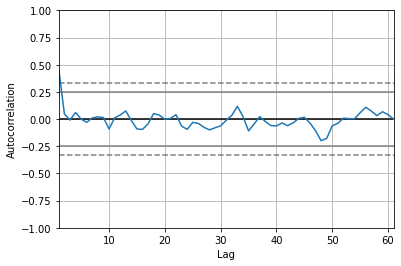

In [9]:
import matplotlib.pyplot as plt

s = training_grouped['Crime ID']

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(s)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

<AxesSubplot: xlabel='Month'>

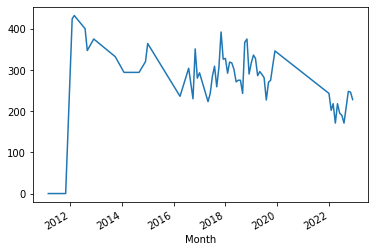

In [10]:
# Growth of burglaries over the years
s.plot()

p-value: 8.112852092933995e-09


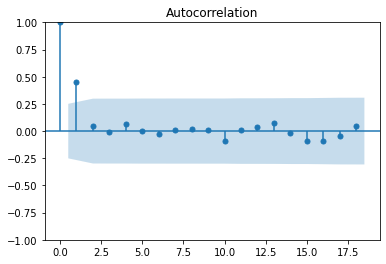

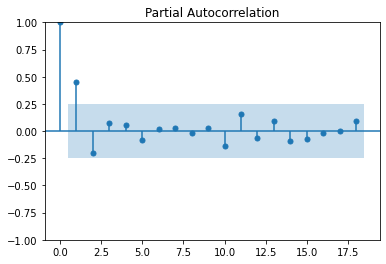

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

training_grouped = df_training.groupby(['Month']).count()

# ADF test to see stationarity
adf_test = adfuller(training_grouped[['Crime ID']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test[1]}')
# Compute autocorrelation
acf = plot_acf(training_grouped[['Crime ID']])

# Compute partial autocorrelation function
pacf = plot_pacf(training_grouped[['Crime ID']])


In [14]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(s, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:               Crime ID   No. Observations:                   61
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -338.848
Date:                Wed, 17 May 2023   AIC                            689.696
Time:                        08:23:20   BIC                            702.262
Sample:                             0   HQIC                           694.611
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2063      0.187     -1.101      0.271      -0.574       0.161
ar.L2         -0.3412      0.195     -1.747      0.081      -0.724       0.042
ar.L3         -0.4617      0.125     -3.694      0.0

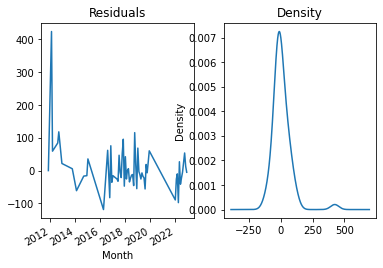

In [17]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

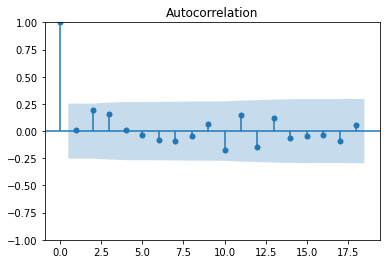

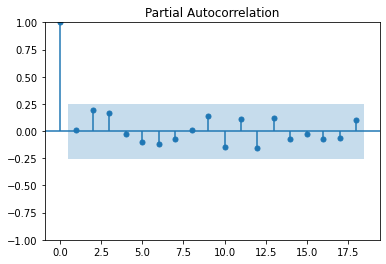

In [18]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



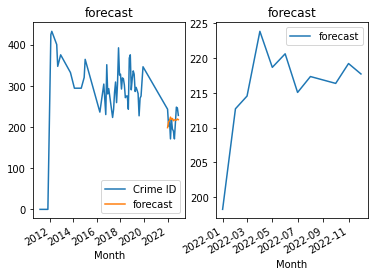

<Figure size 720x720 with 0 Axes>

In [27]:
forecast_test = model_fit.forecast(len(validation_grouped))
validation_grouped['forecast'] = list(forecast_test)

fig1, ax1 = plt.subplots(1,2)
training_grouped[['Crime ID']].plot(title='Original', ax=ax1[0])
validation_grouped[['forecast']].plot(title='forecast', ax=ax1[0])
validation_grouped[['forecast']].plot(title='forecast', ax=ax1[1])
plt.figure(figsize=(10,10))
plt.show()

In [ ]:
from police_api import PoliceAPI
api = PoliceAPI()

n = api.locate_neighbourhood(51.657214, -0.205064)
n

<Neighbourhood> E05013644